# DS4440: HW3

In this homework, we'll do some real "interpretability" type stuff! In particular, we'll start with a simple MLP for MNIST image classification, and then

We've covered what you need from ``NNSight`` in lectures, but here's a [refresher notebook](https://colab.research.google.com/drive/1SdEDGoJ0eN0ADuYhpjBfsDdVYP6texv_?usp=sharing) that should give you what you need here!

# Starter code

This is code we saw in lecture (on "[computation graphs](https://colab.research.google.com/drive/1VPe3-pTjEFiNyxBGCTD8pCAxGEuqyFJ2#scrollTo=5Ri9lvFnlmqs)").

In [1]:
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms

import torch
import torch.nn as nn
import torch.optim as optim

import sklearn
from sklearn.metrics import accuracy_score

import numpy as np


# we need to convert images to tensors; this is very naive
img_transform = transforms.Compose([
    transforms.ToTensor()
])

MNIST_train = datasets.MNIST(root='./data', train=True, download=True,
                             transform=transforms.ToTensor())

# remove last 16 elements from x and y
print(len(MNIST_train))
MNIST_test = datasets.MNIST(root='./data', train=False, download=True,
                            transform=transforms.ToTensor())
MNIST_test = torch.utils.data.Subset(MNIST_test, range(len(MNIST_test)-16))
print(len(MNIST_test))

train_loader = torch.utils.data.DataLoader(MNIST_train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(MNIST_test, batch_size=32)

60000
9984


In [2]:
class MLP(nn.Module):

  def __init__(self):
    super().__init__() # the correct (tm) way!
    self.i = nn.Linear(28**2, 32)
    self.a = nn.Sigmoid()
    self.o = nn.Linear(32, 10)
    self.sm = nn.Softmax(dim=1)

  def forward(self, X):

    # the reason we do this is because MNIST images
    # have dimension (1 x 28 x 28), so X will have
    # dims (BATCH_SIZE x 1 x 28 x 28) -- we collapse
    # them here.
    X = X.view(-1, 28**2)

    h = self.i(X)
    h = self.a(h)
    y_hat = self.o(h)
    y_hat = self.sm(y_hat)
    return y_hat

In [3]:
def train(m, train_data, epochs=10, learning_rate=.5, cuda=True):
  optimizer = optim.SGD(m.parameters(), lr=learning_rate)
  L = torch.nn.CrossEntropyLoss() # our loss

  for epoch in range(epochs):
      epoch_loss = 0
      for batch_index, (X, y) in enumerate(train_data):
        if cuda: 
          X, y = X.cuda(), torch.tensor([y]).cuda()
        else: 
           y = torch.tensor([y])
        #print(f'Shape of X: {X.shape}')

        # don't forget to do this!!
        optimizer.zero_grad()

        # make our predictions, under current weights
        y_hat = m(X)

        # run through our loss function, given y
        loss = L(y_hat, y)

        # take a backward pass through computation
        # graph; this is where the auto-diff happens!
        loss.backward()

        # accumulate loss
        epoch_loss += loss.item()

        # step the optimizer -- update our params
        # using accumulated gradients.
        optimizer.step()

      print("epoch loss", epoch_loss)


In [4]:
m = MLP()
train(m, MNIST_train, epochs=10, cuda=False)

epoch loss 95173.18201744556
epoch loss 92443.45861268044
epoch loss 92160.21010231972
epoch loss 91999.92939209938
epoch loss 91563.24205183983
epoch loss 91508.31435728073
epoch loss 91460.30840146542
epoch loss 91438.48383772373
epoch loss 91088.68096399307
epoch loss 91233.51900625229


In [5]:
def batch_make_preds(m, dataloader, cuda=False):
    y_hat_test, y_true = [], []
    for i, (X, y) in enumerate(dataloader):
        if cuda: 
            preds = m(X.cuda()).detach().cpu().numpy()
            y_hat_test.extend(np.argmax(preds, axis=1))
            y_true.extend(y.cpu().numpy())
        else:
            preds = m(X).detach().numpy()
            y_hat_test.extend(np.argmax(preds, axis=1))
            y_true.extend(y.numpy())
    return y_hat_test, y_true

In [6]:
y_hat_test, y_true = batch_make_preds(m, test_loader, cuda=False)
print(accuracy_score(y_hat_test, y_true))

0.9452123397435898


# Q1 (10 pts): More layerz

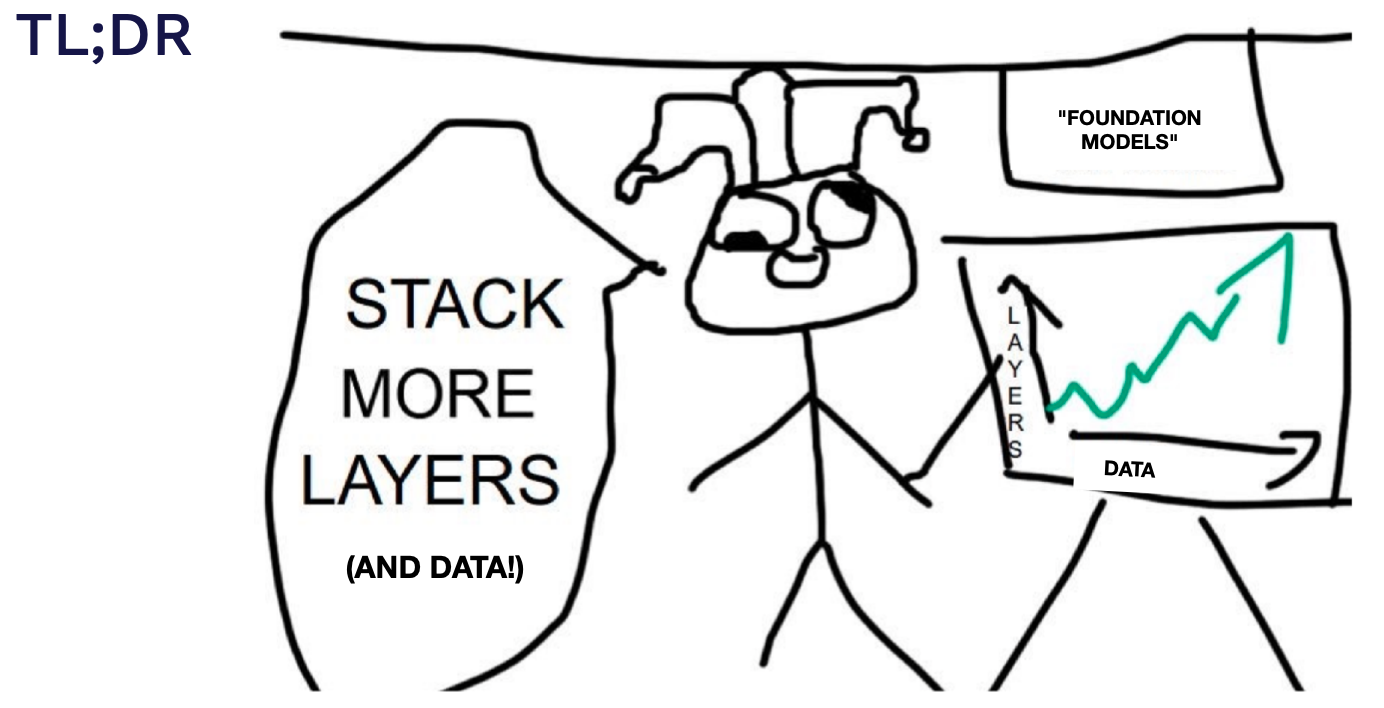

Create a new version of the MLP above (call it `MLP2`) by introducing an additional hidden layer, make it 16 dimensions. Be sure to use a non-linear activation. Verify that you get "reasonable" performance (say $> .9$ accuracy) with this version. This may require additional epochs.

In [18]:
class MLP2(nn.Module):

  def __init__(self):
    super().__init__()
    # TODO
    self.i = nn.Linear(28**2, 32)
    self.a1 = nn.Sigmoid()
    self.h1 = nn.Linear(32, 16)
    self.a2 = nn.Sigmoid()
    self.h2 = nn.Linear(16, 10)
    self.o = nn.Softmax(dim=1)

  def forward(self, X):

    # the reason we do this is because MNIST images
    # have dimension (1 x 28 x 28), so X will have
    # dims (BATCH_SIZE x 1 x 28 x 28) -- we collapse
    # them here.
    X = X.view(-1, 28**2)

    # TODO
    h = self.i(X)
    h = self.a1(h)
    h = self.h1(h)
    h = self.a2(h)
    y_hat = self.h2(h)
    y_hat = self.o(y_hat)
    return y_hat

In [19]:
m2 = MLP2()
train(m2, MNIST_train, epochs=5, learning_rate=0.1, cuda=False)

epoch loss 110180.5582382679
epoch loss 95039.8076441288
epoch loss 91901.0969837904
epoch loss 91420.3678547144
epoch loss 91017.96751141548


In [20]:
y_hat_test, y_true = batch_make_preds(m2, test_loader, cuda=False)
print(accuracy_score(y_hat_test, y_true))

0.9399038461538461


# Q2 (50 pts): Probing (or, what's in the first hidden layer?)

One question that comes up in interpretability work often is: What information do learned representations store? Here you will see if you can, with a single linear layer, decode MNIST class labels from the first hidden layer in your modified MLP (`MLP2`).

Specifically, your task is to:

* Assemble a bunch of (`x`, `y`) pairs from the training data where `x` is the *first* hidden state, following the activation. As a sanity check, also implement a version where you use the penultimate hidden layer---the results here should be ~the same as for `MLP2` itself (why?)
* Train a classification model using this data, but the `x` values should be **frozen**, i.e., you are not to backprop through `MLP2`!
* Evaluate the performance of this on both the train and test `MNIST` data. How well are you able to do?

In [10]:
!pip3 install nnsight
import nnsight
from nnsight import NNsight

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Owner\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [23]:
def batch_make_Xy(m, dataloader, use_first_hiddens=True, cuda=False):
  '''
  Assemble "inputs" as hidden states for all batches in dataloader; also
  return batched labels for convienence.

  If use_first_hiddens is True, you should take the activations at the
  first layer (after activations). Otherwise, take the activations at the
  second (penultimate) layer.
  '''
  Xh, y_probes = [], []
  model = NNsight(m)
  model.zero_grad()
  '''
  TODO!
  - Iterate over all batches in the train loader, and for each *use nnsight*
    to save hidden state actions at either the first or second layer (following
    activations)
  - Also assemble the corresponding target labels (ys)
  - Return both these X vectors and targets; be sure that the activations
    are *detached* from the computation graph!
  '''
  # TODO
  for (X, y) in dataloader:
    if cuda:
      X, y = X.cuda(), y.cuda()
    y_probes.append(y)
    
    with model.trace(X) as tracer:
      if use_first_hiddens:
        hidden_states = tracer.h1.input.detach().save()
      else:
        hidden_states = tracer.h2.input.detach().save()
      Xh.append(hidden_states)

  # Assuming Xh = activation vectors, and y_probes corresponding labels
  return Xh, y_probes

In [24]:
print("making train data...")
train_Xh, train_y_probes = batch_make_Xy(m2, train_loader)
print("done. making test data... ")
test_Xh, test_y_probes = batch_make_Xy(m2, test_loader)

making train data...
done. making test data... 


In [25]:
class ProbeModel(nn.Module): 
    def __init__(self, input_dim):
        super().__init__()
        self.l1 = nn.Linear(input_dim, 10)
        self.sm = nn.Softmax(dim=1)

    def forward(self, X):
        x = self.l1(X)
        x = self.sm(x)
        return x
        

In [26]:
class ProbeDataset(torch.utils.data.Dataset):
  # TODO implement this bit to provide a nice
  # interface to your (X, y) data
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

probe_train_dataset = ProbeDataset(train_Xh, train_y_probes)
probe_test_dataset = ProbeDataset(test_Xh, test_y_probes)

In [27]:
input_shape = train_Xh[0].shape[0]
# TODO define a probing model
probe_model = ProbeModel((probe_train_dataset.X[0]).shape[0])

In [28]:
def trainProbe(m, train_data, epochs=10, learning_rate=0.5, cuda=True):
    optimizer = optim.SGD(m.parameters(), lr=learning_rate)
    L = torch.nn.CrossEntropyLoss()
    
    for epoch in range(epochs): 
        epoch_loss = 0 
        for batch_index, (X, y) in enumerate(train_data):
            if cuda:
                X, y = X.cuda(), y.cuda()
            optimizer.zero_grad()
            y_hat = m(X)
            loss = L(y_hat, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
        print("epoch loss", epoch_loss)

trainProbe(probe_model, probe_train_dataset, epochs=5, learning_rate=0.1, cuda=False)

epoch loss 3556.5666624307632
epoch loss 3110.346070766449
epoch loss 3064.0407202243805
epoch loss 3045.2959020137787
epoch loss 3033.189730644226


In [29]:
y_hat_probe_test, y_probe_true = batch_make_preds(probe_model, probe_test_dataset, cuda=False)
print(accuracy_score(y_hat_probe_test, y_probe_true))

0.86328125


# Q3 (40 pts): Visualizing representations and gradients

Finally, let's visualize some model internals. In particular, the ask here is for you to: Assemble hidden states and gradients (separately) of the hidden layer in `MLP2` over *over the test set* for different classes (digits), dimensionality reduce them, and then plot them.

We use ``NNsight`` to access both hidden representations and their gradients.

In [31]:
def visualizeData(m, dataloader, cuda=True):
    grads, hiddens, ys = [],[],[]
    for (X, y) in dataloader: 
        if cuda: 
            X, y = X.cuda(), y.cuda()
        ys.append(y)

        with m.trace(X): 
            hidden_states = m.h1.output.detach().save()
            hiddens.append(hidden_states)
            hidden_grads = m.h1.output.grad.detach().save()
            grads.append(hidden_grads)
            loss = m.output.sum()
            loss.backward()
    return grads, hiddens, ys

model = NNsight(m2)
grads, hiddens, ys = visualizeData(model, test_loader, cuda=False)

In [32]:
grads_np = np.concatenate(grads)
hiddens_np = np.concatenate(hiddens)
y_list = np.concatenate(ys)

In [33]:
from sklearn.manifold import TSNE

In [34]:
grads_embedded = TSNE(n_components=2).fit_transform(grads_np)

In [35]:
hiddens_embedded = TSNE(n_components=2).fit_transform(hiddens_np)

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

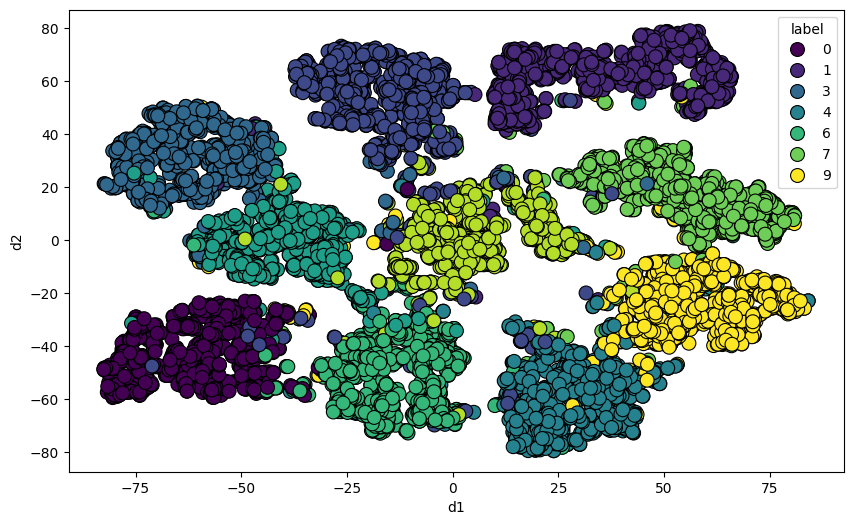

In [ ]:
# hidden states
df = pd.DataFrame(hiddens_embedded, columns=['d1', 'd2'])
df['label'] = y_list

plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=df, x='d1', y='d2', hue='label',
                               palette='viridis', s=100, edgecolor='k')

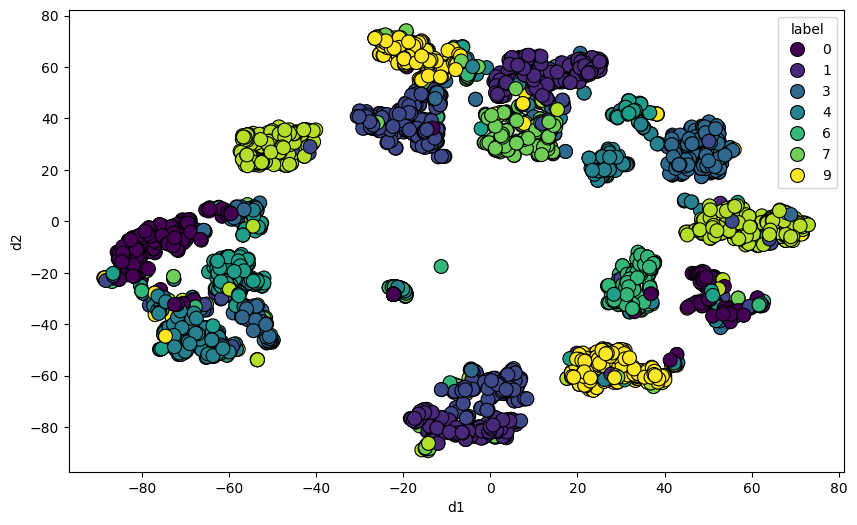

In [38]:
# Grads
df = pd.DataFrame(grads_embedded, columns=['d1', 'd2'])
df['label'] = y_list

plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=df, x='d1', y='d2', hue='label',
                               palette='viridis', s=100, edgecolor='k')


*Observations* TODO enter comments about the above plots / your interpretation.
- After reducing dimensions, the hidden states are able to provide a rough estimation of the classififcation of the image(s). This is because it forms distinct clusters of images of similar labels together. 
- After reducing dimensions, the gradients do not tell us much about the classification of the image(s). Images of different labels are clusted relatively closely together, not telling us about each images' classification.